In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.tabular.all import *
from wwf.tab.export import *

In [3]:
from bnbsl import *

In [4]:
SEASON = '21'
set_seed(int(SEASON))

## Data preparation

In [5]:
path = Path()
path_data = Path('data')

In [6]:
df = pd.read_csv(path_data/'data.csv', dtype={'HC':'float', 'AC':'float'}, parse_dates=['Date'])

In [7]:
div = ['E0', 'E1', 'E2', 'D1', 'D2', 'SP1', 'SP2', 'I1', 'I2', 'F1', 'F2']
df = df[(df.Div.isin(div)) & (df.Season >= 18) & (df.Season <= 21)]

# Drop NA corner
df = df.dropna().reset_index(drop=True)

In [8]:
add_datepart(df, 'Date');

In [9]:
# Time-weighted
df['weight'] = np.exp(-(df.Elapsed.max() - df.Elapsed) / (3600*24*365))
df['weight'] = df['weight'] / df['weight'].mean()

In [10]:
procs = [Categorify, FillMissing, Normalize]

In [11]:
valid_idx = list(df.query('Season == 21').index)

In [12]:
splitter = IndexSplitter(valid_idx)
splits = splitter(range_of(df))

In [13]:
splits

((#12557) [0,1,2,3,4,5,6,7,8,9...],
 (#1772) [918,919,920,921,922,923,924,925,926,927...])

In [14]:
y_names = ['HC', 'AC']
cat_names = ['Div', 'HomeTeam', 'AwayTeam', 'Dayofweek']
# cont_names = list(df.columns[df.columns.str.contains('For') | df.columns.str.contains('Against')]) + ['Year', 'Month', 'Week', 'Day', 'Dayofyear']
cont_names = list(df.columns[df.columns.str.contains('Avg')]) + ['Year', 'Month', 'Week', 'Day', 'Dayofyear']

In [15]:
y_block = RegressionBlock(n_out=2)

In [16]:
df.sample(10)

,Div,HomeTeam,AwayTeam,FTHG,FTAG,HS,AS,HST,AST,HC,...,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,weight
8338,F2,Auxerre,Grenoble,4.0,0.0,8.0,15.0,5.0,7.0,4.0,...,4,355,False,False,False,False,False,False,1.545350e+09,0.175408
69,D1,Wolfsburg,Bayern Munich,1.0,3.0,8.0,13.0,1.0,11.0,2.0,...,5,293,False,False,False,False,False,False,1.539994e+09,0.148006
5069,E1,Stoke,Huddersfield,2.0,1.0,6.0,15.0,2.0,4.0,3.0,...,5,254,False,False,False,False,False,False,1.631318e+09,2.678846
3276,E0,Crystal Palace,Brighton,1.0,1.0,8.0,8.0,3.0,4.0,6.0,...,0,270,False,False,False,False,False,False,1.632701e+09,2.798887
12800,SP2,Gimnastic,Tenerife,1.0,1.0,8.0,18.0,4.0,6.0,6.0,...,0,232,False,False,False,False,False,False,1.534723e+09,0.125227
7149,F1,Paris SG,Nantes,1.0,0.0,23.0,11.0,3.0,2.0,9.0,...,5,356,False,False,False,False,False,False,1.545437e+09,0.175889
3273,E0,Watford,Newcastle,1.0,1.0,15.0,20.0,4.0,6.0,5.0,...,5,268,False,False,False,False,False,False,1.632528e+09,2.783592
2291,E0,Crystal Palace,Watford,1.0,2.0,15.0,16.0,6.0,2.0,7.0,...,5,12,False,False,False,False,False,False,1.547251e+09,0.186306
14119,SP2,Almeria,Logrones,2.0,1.0,13.0,15.0,6.0,5.0,3.0,...,0,144,False,False,False,False,False,False,1.621814e+09,1.981821
8294,F2,Lorient,Paris FC,2.0,1.0,12.0,6.0,4.0,1.0,3.0,...,4,313,False,False,False,False,False,False,1.541722e+09,0.156342


In [17]:
to = TabularPandas(df, procs=procs, cat_names=cat_names, cont_names=cont_names, 
                   y_names=y_names, y_block=y_block, splits=splits)

In [18]:
to.cat_names, to.cont_names

((#4) ['Div','HomeTeam','AwayTeam','Dayofweek'],
 (#29) ['FTHGLast5Avg','HSLast5Avg','HSTLast5Avg','HCLast5Avg','FTAGLast5Avg','ASLast5Avg','ASTLast5Avg','ACLast5Avg','HomeFTGForLast5Avg','HomeSForLast5Avg'...])

In [19]:
display_df(to.xs.iloc[-2:])

,Div,HomeTeam,AwayTeam,Dayofweek,FTHGLast5Avg,HSLast5Avg,HSTLast5Avg,HCLast5Avg,FTAGLast5Avg,ASLast5Avg,ASTLast5Avg,ACLast5Avg,HomeFTGForLast5Avg,HomeSForLast5Avg,HomeSTForLast5Avg,HomeCForLast5Avg,AwayFTGForLast5Avg,AwaySForLast5Avg,AwaySTForLast5Avg,AwayCForLast5Avg,HomeFTGAgainstLast5Avg,HomeSAgainstLast5Avg,HomeSTAgainstLast5Avg,HomeCAgainstLast5Avg,AwayFTGAgainstLast5Avg,AwaySAgainstLast5Avg,AwaySTAgainstLast5Avg,AwayCAgainstLast5Avg,Year,Month,Week,Day,Dayofyear
14327,11,237,223,7,0.563297,-0.280982,-0.123153,-0.908917,1.103342,0.146316,0.425838,0.201665,0.175251,0.333893,-0.143902,-1.089785,-1.188423,-0.781216,-1.689564,-0.258867,-1.59626,-0.61759,-1.129281,-1.583442,-0.157138,-1.518301,-0.775401,-1.091222,1.464103,1.128535,1.158947,1.355390,1.223487
14328,11,80,100,1,0.563297,-0.923755,-0.407276,-1.183442,0.400344,-0.169676,0.106334,-0.252603,-0.491326,1.013746,-0.143902,-0.500629,1.134481,0.339462,0.567362,-0.113813,-0.55248,-0.61759,-0.504017,-1.141355,-0.510525,0.332368,-0.775401,-1.976788,1.464103,1.128535,1.217528,1.466915,1.231896


### To other packages (e.g. Scikit-learn, LightGBM, XGBoost)

In [20]:
from sklearn.multioutput import MultiOutputRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor, XGBRFRegressor

In [21]:
X_train, y_train = to.train.xs, to.train.ys.values
X_test, y_test = to.valid.xs, to.valid.ys.values

In [22]:
X_train.shape, y_train.shape

((12557, 33), (12557, 2))

In [23]:
X_test.shape, y_test.shape

((1772, 33), (1772, 2))

## LightGBM

In [24]:
fit_params = {'feature_name':list(X_test.columns), 'categorical_feature':cat_names}

In [25]:
m_lgbm = MultiOutputRegressor(LGBMRegressor(objective='poisson', n_estimators=100, n_jobs=-1, reg_lambda=1.0))
m_lgbm.fit(X_train, y_train, **fit_params)

/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


MultiOutputRegressor(estimator=LGBMRegressor(objective='poisson',
                                             reg_lambda=1.0))

In [26]:
import lightgbm as lgbm

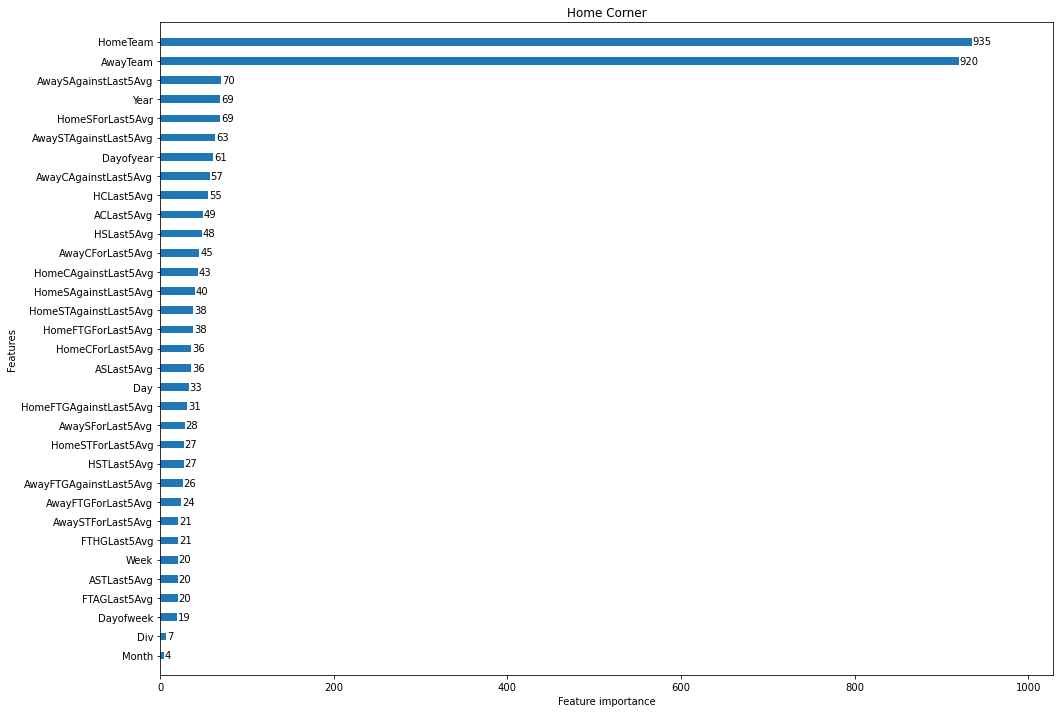

In [27]:
lgbm.plot_importance(m_lgbm.estimators_[0], figsize=(16, 12), title='Home Corner', max_num_features=40, height=0.4, grid=False);

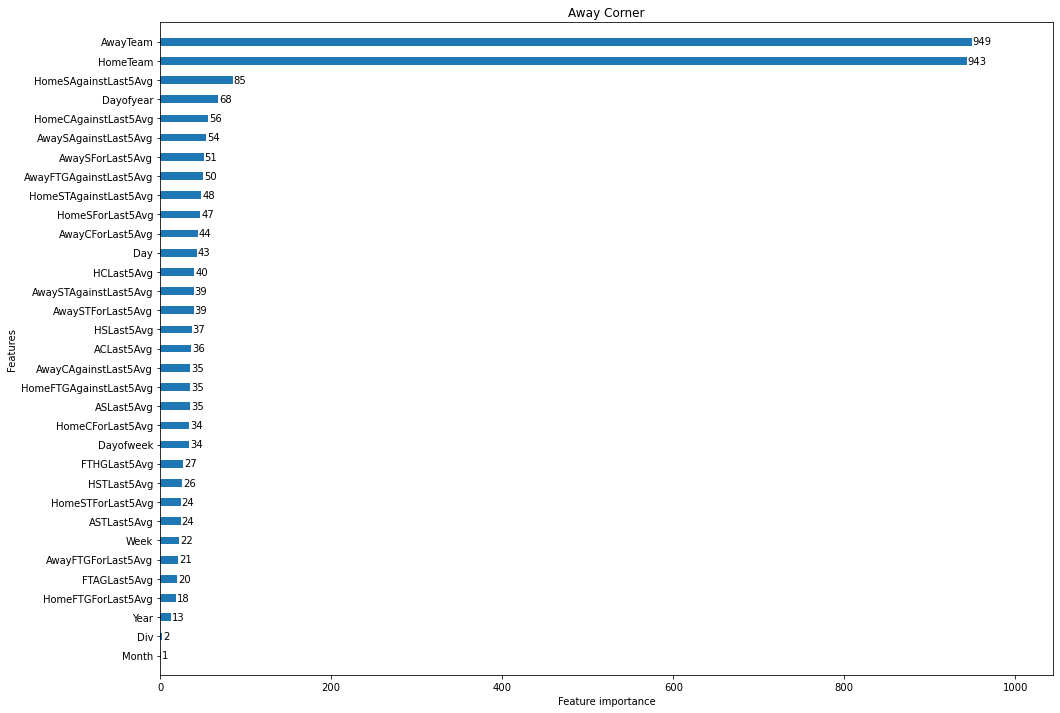

In [28]:
lgbm.plot_importance(m_lgbm.estimators_[1], figsize=(16, 12), title='Away Corner', max_num_features=40, height=0.4, grid=False);

## XGBoost

In [29]:
m_xgb = MultiOutputRegressor(XGBRegressor(objective='count:poisson', n_estimators=100, n_jobs=-1, tree_method='exact'))
m_xgb.fit(X_train, y_train)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, gamma=None,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=None,
                                            max_delta_step=None, max_depth=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=-1,
                                            num_parallel_tree=None,
                                            objective='count:poisson',
                                            rand

In [30]:
import xgboost as xgb

In [31]:
for i in range(0, 2):
    m_xgb.estimators_[i].get_booster().feature_names = list(X_test.columns)

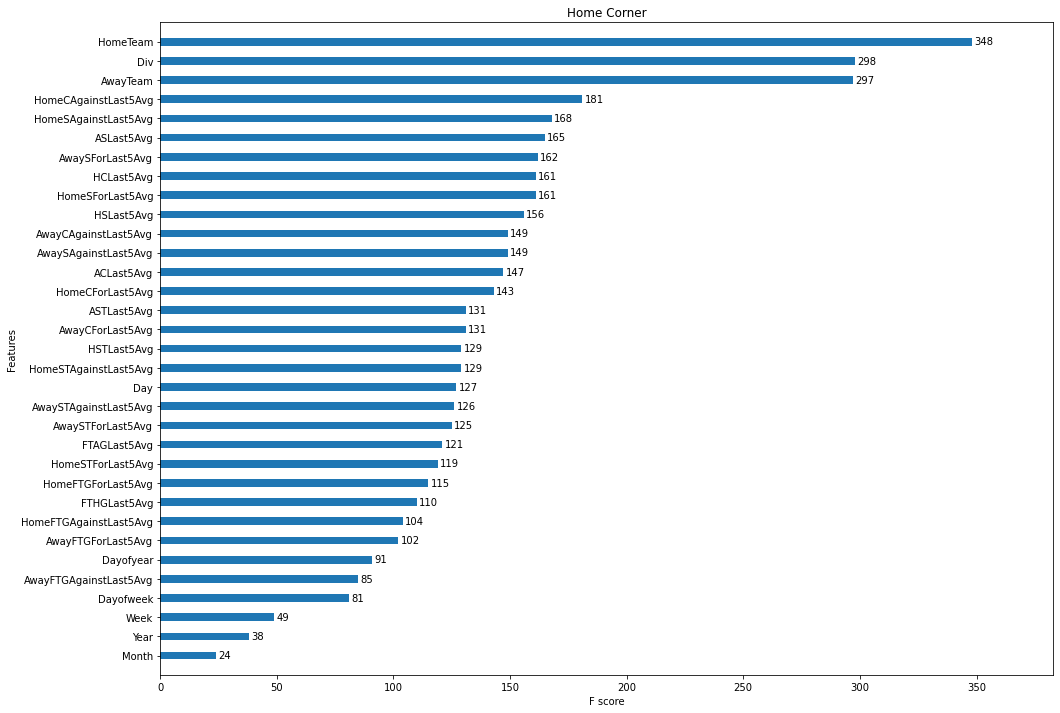

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
xgb.plot_importance(m_xgb.estimators_[0], title='Home Corner', max_num_features=40, height=0.4, grid=False, ax=ax);

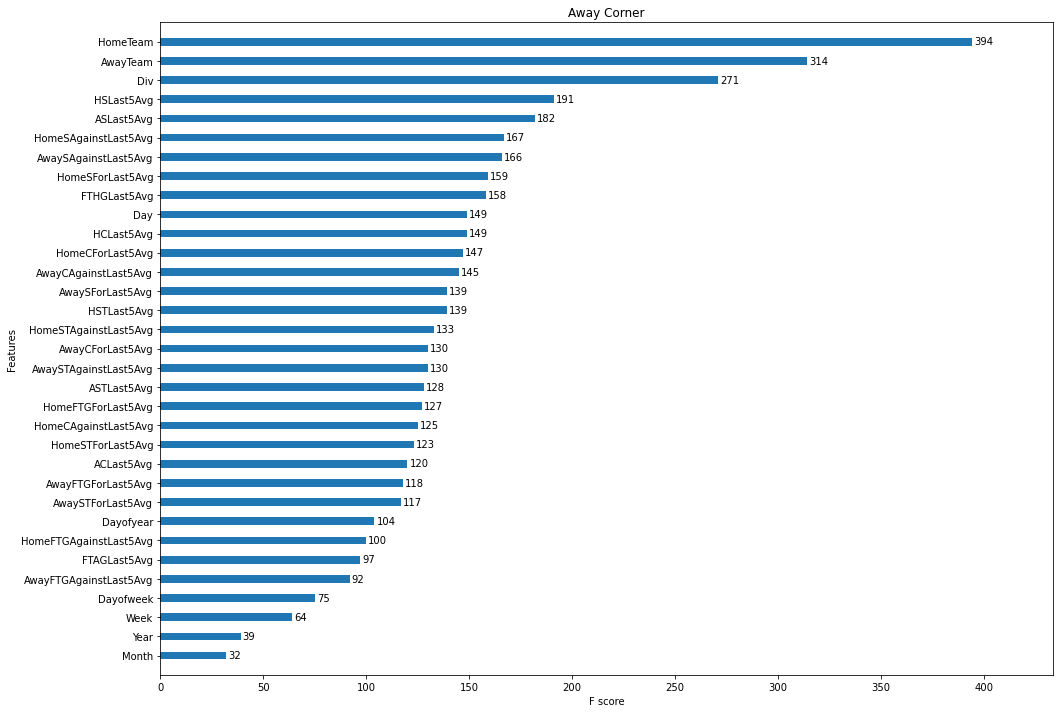

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
xgb.plot_importance(m_xgb.estimators_[1], title='Away Corner', max_num_features=40, height=0.4, grid=False, ax=ax);

## Poisson

In [34]:
bs = 64
dls = to.dataloaders(bs=bs)
dls.show_batch()

,Div,HomeTeam,AwayTeam,Dayofweek,FTHGLast5Avg,HSLast5Avg,HSTLast5Avg,HCLast5Avg,FTAGLast5Avg,ASLast5Avg,ASTLast5Avg,ACLast5Avg,HomeFTGForLast5Avg,HomeSForLast5Avg,HomeSTForLast5Avg,HomeCForLast5Avg,AwayFTGForLast5Avg,AwaySForLast5Avg,AwaySTForLast5Avg,AwayCForLast5Avg,HomeFTGAgainstLast5Avg,HomeSAgainstLast5Avg,HomeSTAgainstLast5Avg,HomeCAgainstLast5Avg,AwayFTGAgainstLast5Avg,AwaySAgainstLast5Avg,AwaySTAgainstLast5Avg,AwayCAgainstLast5Avg,Year,Month,Week,Day,Dayofyear,HC,AC
0,F1,Lille,Guingamp,6,2.0,13.6,4.8,2.8,1.4,11.2,4.0,5.4,1.6,13.8,4.8,3.4,1.4,12.2,4.4,5.4,1.8,10.0,4.2,5.2,2.6,16.000000,6.8,7.4,2018.0,8.0,34.000000,26.000000,238.000001,4.0,4.0
1,E0,Chelsea,Cardiff,5,1.6,21.0,6.4,6.8,1.0,12.6,3.8,5.6,2.0,16.4,5.2,4.8,0.4,13.2,2.4,4.6,1.2,10.2,3.2,3.4,1.0,9.400000,4.6,6.0,2018.0,9.0,37.000000,15.000000,258.000000,5.0,4.0
2,F1,Monaco,Marseille,6,1.2,14.6,4.2,6.4,2.2,14.0,4.6,4.8,0.8,12.4,4.6,4.0,0.8,10.0,2.8,4.6,2.4,13.4,4.8,5.4,0.6,11.800000,4.2,6.6,2019.0,9.0,37.000000,15.000000,258.000000,6.0,4.0
3,I1,Verona,Bologna,0,0.6,8.8,4.4,5.6,1.0,14.4,5.8,5.0,0.8,12.0,4.6,7.2,1.0,12.4,4.6,6.2,1.4,8.8,3.8,2.8,2.4,14.800000,7.0,5.8,2021.0,5.0,20.000000,17.000000,136.999999,4.0,4.0
4,F2,Paris FC,Nancy,4,0.8,9.2,3.8,5.8,0.4,5.8,3.4,5.2,1.0,9.2,4.6,3.8,1.4,8.6,3.8,4.8,1.0,9.8,5.4,7.0,1.6,6.200000,2.6,2.0,2018.0,8.0,31.000000,3.000000,215.000000,5.0,1.0
5,SP2,Almeria,Numancia,6,0.8,11.6,4.2,7.0,1.0,11.4,3.8,4.6,0.6,12.2,3.8,5.8,2.0,13.0,4.2,5.8,0.4,8.2,2.4,4.2,1.4,8.000000,3.4,4.6,2019.0,2.0,6.000000,10.000000,40.999997,7.0,3.0
6,E2,Wigan,Rochdale,1,1.6,8.6,3.2,4.0,1.8,10.4,3.4,4.4,1.4,6.0,2.2,3.6,1.2,12.0,3.2,4.6,1.4,16.6,5.0,9.4,1.6,14.800000,4.8,5.4,2020.0,12.0,51.000000,15.000000,350.000001,3.0,2.0
7,E1,Sheffield Weds,Birmingham,2,1.0,12.4,4.4,4.4,1.0,16.0,3.6,5.8,1.0,14.8,4.4,7.6,1.2,16.6,4.8,7.4,1.2,11.6,3.8,4.2,1.4,12.200000,4.0,6.2,2019.0,11.0,47.999999,26.999999,330.999998,12.0,1.0
8,I2,Pordenone,Brescia,1,1.4,11.8,4.2,7.0,1.0,11.0,3.2,4.6,0.8,9.8,3.2,6.0,1.8,14.2,5.4,5.6,0.6,15.6,5.4,5.4,1.8,15.000000,6.2,5.0,2020.0,12.0,51.000000,15.000000,350.000001,4.0,6.0
9,SP2,Albacete,Alcorcon,0,0.8,10.6,3.6,5.6,1.0,9.0,3.4,5.6,0.6,10.0,4.0,5.8,1.6,10.4,3.8,4.4,1.6,7.8,3.2,2.8,1.4,8.600001,3.0,4.2,2021.0,5.0,18.000000,3.000000,122.999999,4.0,1.0


In [35]:
learn = tabular_learner(dls, layers=[240, 120])

In [36]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(12, 6)
    (1): Embedding(268, 37)
    (2): Embedding(268, 37)
    (3): Embedding(8, 5)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(29, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=114, out_features=240, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(240, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=240, out_features=120, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=120, out_features=2, bias=True)
    )
  )
)

In [37]:
learn.loss_func = BaseLoss(partial(nn.PoissonNLLLoss, log_input=True, full=True), floatify=True)

SuggestedLRs(valley=0.005248074419796467)

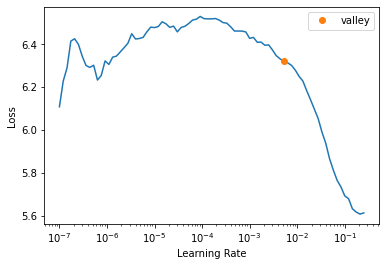

In [38]:
learn.lr_find()

In [39]:
learn.fit_one_cycle(5, 3e-2)

epoch,train_loss,valid_loss,time
0,2.621409,2.612948,00:01
1,2.383794,2.395009,00:01
2,2.365367,2.399541,00:01
3,2.327886,2.373993,00:01
4,2.272749,2.390420,00:01


In [40]:
df.query('Season==21 and HomeTeam=="Tottenham" and AwayTeam=="Man City"')

,Div,HomeTeam,AwayTeam,FTHG,FTAG,HS,AS,HST,AST,HC,...,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,weight
3226,E0,Tottenham,Man City,1.0,0.0,13.0,18.0,3.0,4.0,3.0,...,6,227,False,False,False,False,False,False,1.628986e+09,2.487837


In [41]:
_, _, params = learn.predict(df.query('Season==21 and HomeTeam=="Tottenham" and AwayTeam=="Man City"')
                               .drop(columns=y_names).iloc[0])

In [42]:
pois_corner_home = torch.distributions.poisson.Poisson(params[0].exp())
pois_corner_away = torch.distributions.poisson.Poisson(params[1].exp())

In [43]:
print(pois_corner_home.mean, pois_corner_home.variance)
print(pois_corner_away.mean, pois_corner_away.variance)

tensor(3.2404) tensor(3.2404)
tensor(5.7232) tensor(5.7232)


In [44]:
corner_home = pois_corner_home.log_prob(torch.arange(0., 15.)).exp()
corner_away = pois_corner_away.log_prob(torch.arange(0., 15.)).exp()
corner = torch.ger(corner_home, corner_away)
mask = torch.zeros_like(corner)

In [45]:
mask = torch.zeros_like(corner)
line = 10.5
for i in range(0, mask.size()[0]):
    for j in range(0, mask.size()[1]):
        if i + j < line: mask[i, j] = 1. 

In [46]:
prob_lo = (corner * mask).sum()
prob_hi = 1 - prob_lo

In [47]:
prob_lo, prob_hi

(tensor(0.7103), tensor(0.2897))

## Negative Binomial

In [48]:
y_names = ['HC', 'AC', 'weight']
y_block = RegressionBlock(n_out=5)

In [49]:
to = TabularPandas(df, procs=procs, cat_names=cat_names, cont_names=cont_names, 
                   y_names=y_names, y_block=y_block, splits=splits)

In [50]:
bs = 64
dls = to.dataloaders(bs=bs)
dls.show_batch()

,Div,HomeTeam,AwayTeam,Dayofweek,FTHGLast5Avg,HSLast5Avg,HSTLast5Avg,HCLast5Avg,FTAGLast5Avg,ASLast5Avg,ASTLast5Avg,ACLast5Avg,HomeFTGForLast5Avg,HomeSForLast5Avg,HomeSTForLast5Avg,HomeCForLast5Avg,AwayFTGForLast5Avg,AwaySForLast5Avg,AwaySTForLast5Avg,AwayCForLast5Avg,HomeFTGAgainstLast5Avg,HomeSAgainstLast5Avg,HomeSTAgainstLast5Avg,HomeCAgainstLast5Avg,AwayFTGAgainstLast5Avg,AwaySAgainstLast5Avg,AwaySTAgainstLast5Avg,AwayCAgainstLast5Avg,Year,Month,Week,Day,Dayofyear,HC,AC,weight
0,F2,Grenoble,Sochaux,1,1.4,11.000000,3.400000,5.6,2.000000e+00,9.8,3.6,4.0,1.4,9.800000,2.8,4.4,0.8,9.6,2.6,5.2,1.4,12.0,4.8,4.6,0.6,12.800000,4.2,4.6,2021.0,4.0,16.000000,20.0,109.999998,6.0,4.0,1.805551
1,D1,Wolfsburg,Hoffenheim,0,2.8,15.600000,6.400000,6.6,1.800000e+00,14.4,4.8,3.6,3.0,14.200000,6.0,5.8,1.0,13.4,3.4,5.0,0.8,10.0,2.8,3.8,2.0,18.600001,7.2,9.4,2019.0,9.0,39.000000,23.0,266.000001,4.0,6.0,0.373635
2,F1,Nice,Toulouse,4,1.2,13.400000,4.600000,5.4,1.200000e+00,10.4,3.4,4.0,0.4,9.200000,2.2,3.6,1.0,13.0,4.4,4.6,1.0,13.6,4.0,7.6,1.8,11.000000,4.2,4.4,2019.0,3.0,11.000000,15.0,73.999997,2.0,6.0,0.220799
3,E2,Blackpool,Walsall,5,0.8,9.000000,2.600000,5.4,1.200000e+00,10.4,4.8,4.6,1.0,6.800000,2.4,3.8,1.4,9.4,3.6,4.6,0.6,8.8,3.0,5.0,1.6,9.400000,2.2,5.4,2019.0,2.0,6.000000,9.0,40.000001,1.0,8.0,0.201160
4,E2,Fleetwood Town,Doncaster,1,0.2,10.800000,3.200000,6.0,1.800000e+00,9.0,4.2,2.8,0.2,11.800000,4.4,3.0,1.8,9.0,4.0,3.2,0.8,13.0,3.4,6.6,0.6,12.400000,3.0,5.4,2021.0,2.0,6.000000,9.0,40.000001,8.0,5.0,1.490460
5,I1,Genoa,Chievo,2,1.8,11.400000,4.400000,5.2,1.200000e+00,9.2,4.2,4.2,1.6,10.200000,4.6,5.6,1.0,8.6,3.8,3.2,2.4,10.0,5.6,3.8,2.6,15.600000,9.2,5.6,2018.0,9.0,39.000000,26.0,269.000002,7.0,4.0,0.138587
6,SP2,Cadiz,Granada,4,3.0,12.400000,5.000000,5.8,1.400000e+00,9.0,2.8,3.4,1.2,10.800000,3.0,4.8,1.0,10.0,2.6,4.4,0.6,10.8,4.4,3.0,0.4,10.800000,3.2,3.6,2019.0,1.0,1.999999,11.0,10.999998,5.0,2.0,0.185796
7,I1,Empoli,Roma,5,1.2,11.400000,4.600000,4.2,8.000000e-01,13.2,6.4,6.0,0.4,10.400000,5.4,5.8,2.0,13.8,8.2,6.8,1.2,14.0,7.6,5.6,1.4,10.800000,4.8,4.6,2018.0,10.0,40.000000,6.0,279.000002,4.0,3.0,0.142436
8,F1,Lyon,Dijon,5,2.6,18.200001,9.399999,7.4,2.987078e-09,9.4,2.4,4.6,2.2,18.399999,7.8,6.8,0.2,9.2,1.8,4.8,1.4,11.0,4.0,3.4,1.6,16.400000,4.2,6.2,2019.0,4.0,14.000000,6.0,96.000001,8.0,3.0,0.234516
9,I1,Cagliari,Torino,4,0.6,9.200000,3.000000,5.2,1.800000e+00,11.8,6.4,3.6,0.2,10.000000,3.8,5.0,1.2,13.2,5.4,4.6,1.2,11.0,6.0,8.0,1.2,8.000000,3.2,3.8,2021.0,2.0,7.000000,19.0,50.000001,8.0,3.0,1.531859


In [51]:
learn_bnb = tabular_learner(dls, layers=[240, 120], n_out=5)

In [52]:
learn_bnb.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(12, 6)
    (1): Embedding(268, 37)
    (2): Embedding(268, 37)
    (3): Embedding(8, 5)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(29, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=114, out_features=240, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(240, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=240, out_features=120, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=120, out_features=5, bias=True)
    )
  )
)

In [53]:
learn_bnb.loss_func = BivariateNegativeBinomialSLNLLLoss()
learn_bnb.loss_func

BivariateNegativeBinomialSLNLLLoss()

SuggestedLRs(valley=0.007699715904891491)

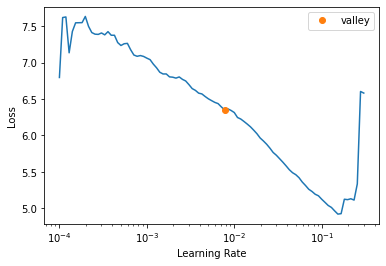

In [54]:
learn_bnb.lr_find(start_lr=1e-04, end_lr=5e-01)

In [55]:
learn_bnb.fit_one_cycle(5, 3e-2)

epoch,train_loss,valid_loss,time
0,3.638562,13.749489,00:01
1,3.426680,13.386896,00:01
2,3.416190,13.411501,00:01
3,3.391308,13.398153,00:01
4,3.292647,13.623950,00:01


In [56]:
df.query('Season==21 and HomeTeam=="Chelsea" and AwayTeam=="Man City"')[['HC', 'AC']]

,HC,AC
3268,4.0,13.0


In [57]:
def predict(self, row):
    "Predict on a Pandas Series"
    dl = self.dls.test_dl(row.to_frame().T)
    dl.dataset.conts = dl.dataset.conts.astype(np.float32)
    inp,preds,_ = self.get_preds(dl=dl, with_input=True, with_decoded=False)
    b = tuplify(inp)
    full_dec = self.dls.decode(b)
    return full_dec,preds[0]

learn_bnb.predict = MethodType(predict, learn_bnb)

In [58]:
_, params = learn_bnb.predict(df.query('Season==21 and HomeTeam=="Chelsea" and AwayTeam=="Man City"')
                                .drop(columns=y_names).iloc[0])

In [59]:
params

tensor([ -1.8051,  -2.4314,   3.8315,   4.7236, -29.4293])

In [60]:
alpha = F.softplus(params[0:2])
mu = F.softplus(params[2:4])
omega = params[4]
# omega = torch.tanh(params[4]) * 50.

total_count = 1. / alpha
logits = torch.log(alpha * mu)

print(alpha, mu, omega)

tensor([0.1523, 0.0843]) tensor([3.8530, 4.7324]) tensor(-29.4293)


In [61]:
bnb_corner = BivariateNegativeBinomialSL(total_count=total_count, omega=omega, logits=logits)

In [62]:
print(bnb_corner.mean, bnb_corner.variance)

tensor([3.8530, 4.7324]) tensor([6.1134, 6.6196])


In [63]:
# Method 1:
corr = omega * torch.sqrt(mu.prod()) * alpha.prod() / ((1.+alpha)**(1./alpha+1.)).prod() / torch.sqrt((1.+alpha*mu).prod())
corr 

tensor(-0.1307)

In [64]:
# Method 2:
# d = 1.-math.exp(-1)
# corr = omega * d**2 * torch.sqrt(mu.prod()*(1.+alpha*mu).prod()) * ((1.+d*alpha*mu)**(-1-1/alpha)).prod()
# corr 

In [65]:
value = torch.cartesian_prod(torch.arange(0., 15.), torch.arange(0., 15.))

/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/torch/functional.py:1069: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1634272482218/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.cartesian_prod(tensors)  # type: ignore[attr-defined]


In [66]:
corner = bnb_corner.log_prob(value).exp()

In [67]:
line = 10.5
mask = value.sum(-1) < line
prob_lo = corner[mask].sum()
prob_hi = 1 - prob_lo

In [68]:
prob_lo, prob_hi

(tensor(0.7356), tensor(0.2644))

In [69]:
1/prob_lo, 1/prob_hi

(tensor(1.3594), tensor(3.7820))

### Train full model

In [70]:
to = TabularPandas(df, procs=procs, cat_names=cat_names, cont_names=cont_names, 
                   y_names=y_names, y_block=y_block)

In [71]:
bs = 64
dls = to.dataloaders(bs=bs)
dls.show_batch()

,Div,HomeTeam,AwayTeam,Dayofweek,FTHGLast5Avg,HSLast5Avg,HSTLast5Avg,HCLast5Avg,FTAGLast5Avg,ASLast5Avg,ASTLast5Avg,ACLast5Avg,HomeFTGForLast5Avg,HomeSForLast5Avg,HomeSTForLast5Avg,HomeCForLast5Avg,AwayFTGForLast5Avg,AwaySForLast5Avg,AwaySTForLast5Avg,AwayCForLast5Avg,HomeFTGAgainstLast5Avg,HomeSAgainstLast5Avg,HomeSTAgainstLast5Avg,HomeCAgainstLast5Avg,AwayFTGAgainstLast5Avg,AwaySAgainstLast5Avg,AwaySTAgainstLast5Avg,AwayCAgainstLast5Avg,Year,Month,Week,Day,Dayofyear,HC,AC,weight
0,I1,Empoli,Sampdoria,6,2.0,16.000000,5.2,6.600000,0.6,12.2,4.2,5.2,1.0,14.6,4.6,7.4,1.2,12.6,3.8,4.6,1.6,12.600000,3.8,4.0,0.6,11.4,3.2,5.0,2021.0,9.0,37.000000,19.0,261.999997,8.0,8.0,2.738209
1,SP2,Mallorca,Cartagena,6,1.2,10.800000,4.6,5.200000,0.6,7.2,1.6,4.4,1.2,11.2,3.6,5.4,1.0,8.6,3.0,3.8,0.4,9.800000,2.0,5.6,0.8,10.4,2.6,3.2,2021.0,3.0,8.999999,7.0,66.000003,7.0,1.0,1.600502
2,SP2,Mirandes,Zaragoza,3,0.4,9.400000,3.2,4.400000,0.4,10.2,2.2,3.8,0.6,8.8,2.8,4.8,0.4,10.4,1.6,5.0,0.8,7.800000,3.0,4.0,0.6,7.8,3.2,6.0,2020.0,10.0,44.000000,29.0,302.999999,2.0,2.0,1.123999
3,D2,Wurzburger Kickers,Paderborn,6,1.0,10.800000,3.8,5.200000,2.2,14.0,6.4,6.0,1.2,8.6,3.2,3.8,2.8,13.6,5.0,6.0,2.6,15.600001,5.2,5.8,2.0,9.6,3.0,4.2,2021.0,5.0,20.000000,23.0,143.000000,3.0,12.0,1.976399
4,I2,Perugia,Benevento,1,0.6,11.800000,3.2,6.000000,2.2,10.2,4.6,5.2,0.4,13.0,2.4,4.8,2.2,11.8,4.4,5.2,1.4,11.200000,4.6,6.0,0.6,10.0,4.6,1.8,2020.0,3.0,10.000001,3.0,62.999997,5.0,5.0,0.582375
5,SP1,Barcelona,Espanol,5,1.8,15.400000,6.0,9.600001,1.0,12.4,3.8,6.4,1.6,13.2,3.8,6.6,1.6,15.0,5.0,7.6,1.6,10.600000,3.4,2.6,1.0,15.6,5.6,6.6,2021.0,11.0,46.000000,20.0,323.999999,4.0,4.0,3.245167
6,SP2,Tenerife,Cadiz,5,0.8,13.400000,4.4,7.200000,0.8,10.8,3.4,4.4,0.8,11.4,3.4,5.0,0.6,12.2,2.6,6.2,1.2,9.400000,3.8,4.0,1.2,10.0,3.6,4.8,2018.0,9.0,39.000000,29.0,271.999998,7.0,3.0,0.139731
7,F1,Marseille,Paris SG,6,2.6,15.200000,4.6,5.000000,2.0,13.6,3.8,4.0,1.6,12.6,4.0,4.8,1.6,14.2,3.4,6.2,1.2,12.600000,4.0,5.0,1.0,9.4,3.4,4.6,2021.0,10.0,42.000000,24.0,297.000001,4.0,5.0,3.013778
8,I2,Lecce,Perugia,5,2.0,17.200001,6.4,7.200000,1.0,10.6,4.0,1.8,2.4,13.8,4.6,4.8,1.2,11.4,4.0,3.6,0.8,10.400000,3.4,3.8,0.4,13.4,3.6,5.2,2021.0,10.0,42.000000,23.0,295.999997,5.0,5.0,3.005532
9,D1,Hertha,Hoffenheim,5,1.8,10.000000,3.8,3.600000,1.0,10.8,3.8,3.8,2.2,11.8,4.6,4.4,1.0,13.4,4.4,5.2,1.0,12.600000,4.8,6.2,1.6,14.0,4.4,6.0,2019.0,10.0,43.000000,26.0,299.000003,4.0,4.0,0.408989


In [72]:
learn_bnb = tabular_learner(dls, layers=[240, 120], n_out=5)

In [73]:
learn_bnb.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(12, 6)
    (1): Embedding(268, 37)
    (2): Embedding(268, 37)
    (3): Embedding(8, 5)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(29, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=114, out_features=240, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(240, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=240, out_features=120, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=120, out_features=5, bias=True)
    )
  )
)

In [74]:
learn_bnb.loss_func = BivariateNegativeBinomialSLNLLLoss()
learn_bnb.loss_func

BivariateNegativeBinomialSLNLLLoss()

SuggestedLRs(valley=0.009941314347088337)

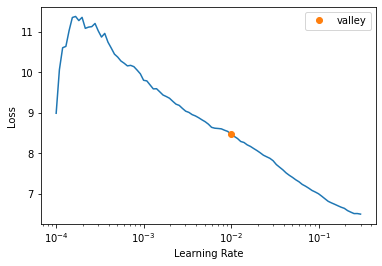

In [75]:
learn_bnb.lr_find(start_lr=1e-04, end_lr=5e-01)

In [76]:
learn_bnb.fit_one_cycle(5, 3e-2)

epoch,train_loss,valid_loss,time
0,4.771441,None,00:02
1,4.675372,None,00:01
2,4.685837,None,00:01
3,4.622369,None,00:01
4,4.512006,None,00:01


/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


In [77]:
learn_bnb.export('models/learn_bnbsl.pkl')

In [78]:
to.export('models/to.pkl')

### t-SNE

In [79]:
df['HomeTeam'].astype('category').cat.categories.values

array(['AFC Wimbledon', 'Accrington', 'Ajaccio', 'Ajaccio GFCO', 'Alaves',
       'Albacete', 'Alcorcon', 'Alessandria', 'Almeria', 'Amiens',
       'Amorebieta', 'Angers', 'Arsenal', 'Ascoli', 'Aston Villa',
       'Atalanta', 'Ath Bilbao', 'Ath Madrid', 'Augsburg', 'Auxerre',
       'Barcelona', 'Barnsley', 'Bastia', 'Bayern Munich', 'Benevento',
       'Betis', 'Beziers', 'Bielefeld', 'Birmingham', 'Blackburn',
       'Blackpool', 'Bochum', 'Bologna', 'Bolton', 'Bordeaux',
       'Bournemouth', 'Bradford', 'Braunschweig', 'Brentford', 'Brescia',
       'Brest', 'Brighton', 'Bristol City', 'Bristol Rvs', 'Burgos',
       'Burnley', 'Burton', 'Cadiz', 'Caen', 'Cagliari', 'Cambridge',
       'Cardiff', 'Cartagena', 'Castellon', 'Celta', 'Chambly',
       'Charlton', 'Chateauroux', 'Chelsea', 'Cheltenham', 'Chievo',
       'Cittadella', 'Clermont', 'Como', 'Cordoba', 'Cosenza', 'Coventry',
       'Cremonese', 'Crewe', 'Crotone', 'Crystal Palace', 'Darmstadt',
       'Derby', 'Dijon', 'D

In [80]:
df['AwayTeam'].astype('category').cat.categories.values

array(['AFC Wimbledon', 'Accrington', 'Ajaccio', 'Ajaccio GFCO', 'Alaves',
       'Albacete', 'Alcorcon', 'Alessandria', 'Almeria', 'Amiens',
       'Amorebieta', 'Angers', 'Arsenal', 'Ascoli', 'Aston Villa',
       'Atalanta', 'Ath Bilbao', 'Ath Madrid', 'Augsburg', 'Auxerre',
       'Barcelona', 'Barnsley', 'Bastia', 'Bayern Munich', 'Benevento',
       'Betis', 'Beziers', 'Bielefeld', 'Birmingham', 'Blackburn',
       'Blackpool', 'Bochum', 'Bologna', 'Bolton', 'Bordeaux',
       'Bournemouth', 'Bradford', 'Braunschweig', 'Brentford', 'Brescia',
       'Brest', 'Brighton', 'Bristol City', 'Bristol Rvs', 'Burgos',
       'Burnley', 'Burton', 'Cadiz', 'Caen', 'Cagliari', 'Cambridge',
       'Cardiff', 'Cartagena', 'Castellon', 'Celta', 'Chambly',
       'Charlton', 'Chateauroux', 'Chelsea', 'Cheltenham', 'Chievo',
       'Cittadella', 'Clermont', 'Como', 'Cordoba', 'Cosenza', 'Coventry',
       'Cremonese', 'Crewe', 'Crotone', 'Crystal Palace', 'Darmstadt',
       'Derby', 'Dijon', 'D

In [81]:
variable = 'HomeTeam'
ix = cat_names.index(variable)

var_vals = list(df[variable].astype('category').cat.categories.values)
nval = len(var_vals)
print(f'Number of values: {nval}')
print(var_vals)

Number of values: 267
['AFC Wimbledon', 'Accrington', 'Ajaccio', 'Ajaccio GFCO', 'Alaves', 'Albacete', 'Alcorcon', 'Alessandria', 'Almeria', 'Amiens', 'Amorebieta', 'Angers', 'Arsenal', 'Ascoli', 'Aston Villa', 'Atalanta', 'Ath Bilbao', 'Ath Madrid', 'Augsburg', 'Auxerre', 'Barcelona', 'Barnsley', 'Bastia', 'Bayern Munich', 'Benevento', 'Betis', 'Beziers', 'Bielefeld', 'Birmingham', 'Blackburn', 'Blackpool', 'Bochum', 'Bologna', 'Bolton', 'Bordeaux', 'Bournemouth', 'Bradford', 'Braunschweig', 'Brentford', 'Brescia', 'Brest', 'Brighton', 'Bristol City', 'Bristol Rvs', 'Burgos', 'Burnley', 'Burton', 'Cadiz', 'Caen', 'Cagliari', 'Cambridge', 'Cardiff', 'Cartagena', 'Castellon', 'Celta', 'Chambly', 'Charlton', 'Chateauroux', 'Chelsea', 'Cheltenham', 'Chievo', 'Cittadella', 'Clermont', 'Como', 'Cordoba', 'Cosenza', 'Coventry', 'Cremonese', 'Crewe', 'Crotone', 'Crystal Palace', 'Darmstadt', 'Derby', 'Dijon', 'Doncaster', 'Dortmund', 'Dresden', 'Duisburg', 'Dunkerque', 'Eibar', 'Ein Frankfurt

In [82]:
# import altair as alt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

emb_mx = to_np(next(learn_bnb.model.embeds[ix].parameters()))
#X_emb = TSNE(n_components=2, perplexity=3).fit_transform(emb_mx)
#X_emb = PCA(n_components=2).fit_transform(emb_mx)
annotation = np.append('Other', np.array(var_vals))

/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' 

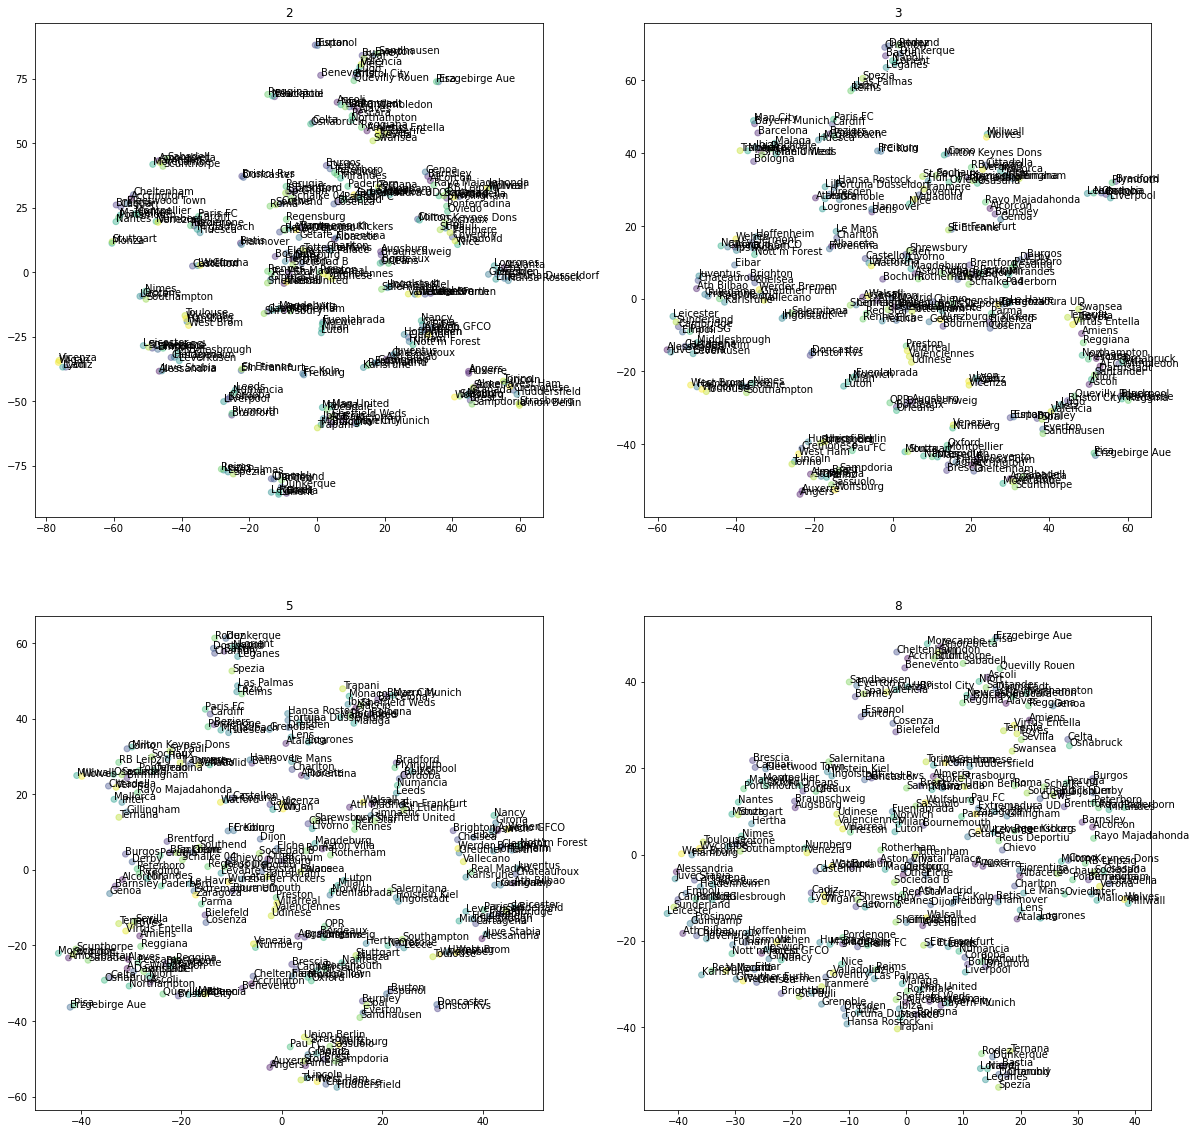

In [83]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(20)
fig.set_figwidth(20)

perplexity = [2, 3, 5, 8]
for ax,perp in zip(axes.flatten(), perplexity):
    X_emb = TSNE(n_components=2, perplexity=perp).fit_transform(emb_mx)
    ax.scatter(X_emb[:,0], X_emb[:,1], c=range(len(annotation)), alpha=0.4)
    for xy,target in zip(X_emb, annotation):
        if isinstance(target, np.str_) or isinstance(target, str):
            text = target
        else:
            text = "%d" % target
        ax.annotate(text=text, xy=(xy[0], xy[1]))
        ax.set_title(perp)

# END